In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, expr, lit, min, max, mean

In [2]:
spark = SparkSession.builder\
    .config("spark.jars", "duckdb.jar") \
    .getOrCreate()

24/04/25 18:07:56 WARN Utils: Your hostname, MacBook-Air-de-Esteban-2.local resolves to a loopback address: 127.0.0.1; using 192.168.1.133 instead (on interface en0)
24/04/25 18:07:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/04/25 18:07:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [7]:
districtes = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:duckdb:../exploited_zone/freshdata_exploited2.db") \
    .option("driver", "org.duckdb.DuckDBDriver") \
    .option("query", '''
        SELECT *
        FROM nova_base
    ''') \
    .load()
districtes.show()

+----+---------+-------------+--------------------+----------------------------------+------------------+
| Any|Trimestre|Nom_Districte|           Nom_Barri|Superfície_mitjana_(m2_construïts)|            Nombre|
+----+---------+-------------+--------------------+----------------------------------+------------------+
|2023|        1|       Gràcia|   la_Vila_de_Gràcia|                             Total|              80.5|
|2023|        2|       Gràcia|   la_Vila_de_Gràcia|                             Total| 81.30000305175781|
|2023|        3|       Gràcia|   la_Vila_de_Gràcia|                             Total|  83.0999984741211|
|2023|        1|       Gràcia|el_Camp_d_en_Gras...|                             Total| 77.30000305175781|
|2023|        2|       Gràcia|el_Camp_d_en_Gras...|                             Total|  71.4000015258789|
|2023|        3|       Gràcia|el_Camp_d_en_Gras...|                             Total|              68.5|
|2023|        1|       Gràcia|             el_

In [31]:
df = districtes.toPandas()

In [12]:
print("Información general del DataFrame: \n")
print(df.info())

Información general del DataFrame: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Any                                 876 non-null    object 
 1   Trimestre                           876 non-null    object 
 2   Nom_Districte                       876 non-null    object 
 3   Nom_Barri                           876 non-null    object 
 4   Superfície_mitjana_(m2_construïts)  876 non-null    object 
 5   Nombre                              876 non-null    float64
dtypes: float64(1), object(5)
memory usage: 41.2+ KB
None


In [19]:
print("Estadística descriptiva agrupat pel tipus d'habitatge: \n")
print(df.groupby('Superfície_mitjana_(m2_construïts)').describe()['Nombre'])

Estadística descriptiva agrupat pel tipus d'habitatge: 

                                    count       mean        std        min  \
Superfície_mitjana_(m2_construïts)                                           
Habitatge nou lliure                219.0  83.411473  39.166685  23.000000   
Habitatge nou protegit              219.0  80.321328  22.785714  48.300000   
Habitatge usat                      219.0  79.152926  24.909658  40.700001   
Total                               219.0  79.478039  26.233325  41.299999   

                                          25%        50%        75%  \
Superfície_mitjana_(m2_construïts)                                    
Habitatge nou lliure                64.935714  73.199997  90.849998   
Habitatge nou protegit              66.487500  73.633334  83.462499   
Habitatge usat                      65.849998  72.199997  80.700001   
Total                               66.599998  72.199997  81.599998   

                                           max 

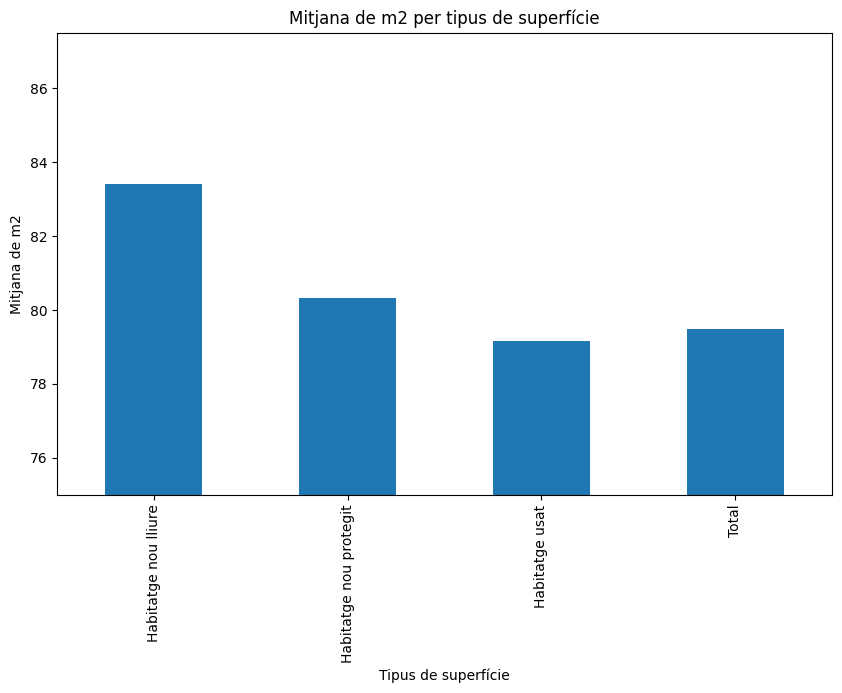

In [37]:
# haz un barplot de la media de Nombre por la Superfície_mitjana_(m2_construïts) que es categórica
plt.figure(figsize=(10, 6))
df.groupby('Superfície_mitjana_(m2_construïts)')['Nombre'].mean().plot(kind='bar')
plt.title('Mitjana de m2 per tipus de superfície')
plt.xlabel('Tipus de superfície')
plt.ylabel('Mitjana de m2')
plt.ylim(75, 87.5)
plt.show()

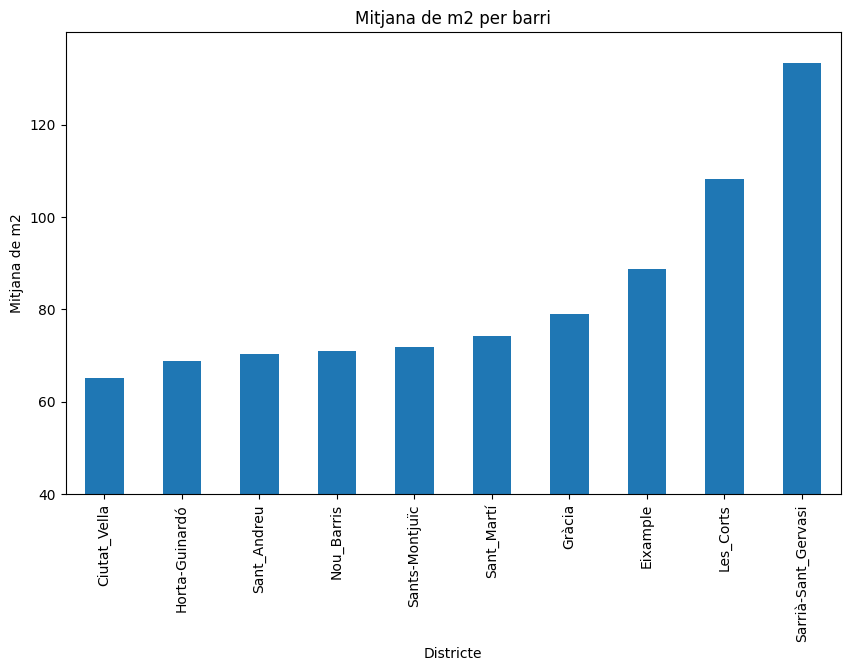

In [46]:
plt.figure(figsize=(10, 6))
df[df['Superfície_mitjana_(m2_construïts)'] == 'Total'].groupby('Nom_Districte')['Nombre'].mean().sort_values().plot(kind='bar')
plt.title('Mitjana de m2 per barri')
plt.xlabel('Districte')
plt.ylabel('Mitjana de m2')
plt.ylim(40, )
plt.show()